In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size':16})

import sciunit
from owtests import OW_HOME
import wcon
import open_worm_analysis_toolbox as owat

In [2]:
OWAT_TESTS = os.path.join(OW_HOME,'tests','owtests','open-worm-analysis-toolbox')

In [3]:
import pandas as pd
path = os.path.join(OWAT_TESTS,'experiment','results.csv')
df = pd.read_csv(path,index_col=0)
for col in ['amplitude_ratio','amplitude_ratio_forward','amplitude_ratio_backward']:
    try:
        df = df[df[col] != 'None']
        df[col] = df[col].astype('float')
    except:
        pass
df.head()

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


,strain,gene,allele,zenodo_id,timestamp,amplitude_ratio,amplitude_ratio_forward,amplitude_ratio_backward
base_name,,,,,,,,
mec-12 (e1605) on food L_2010_10_01__12_27_42__3,AQ1031,mec-12,e1605,1016623,2010-10-01 12:27,0.695751,0.712495,0.696811
mec-12 (e1605) on food L_2010_10_28__12_59_53__7,AQ1031,mec-12,e1605,1016892,2010-10-28 12:59,0.708843,0.718315,0.733603
mec-12 (e1605) on food R_2010_09_30__12_28_20__7,AQ1031,mec-12,e1605,1023874,2010-09-30 12:28,0.693943,0.703139,0.700306
mec-12 (e1605) on food R_2010_09_30__12_28_20__7,AQ1031,mec-12,e1605,129923,2010-09-30 12:28,0.693943,0.703139,0.700306
mec-12 (e1605) on food R_2010_11_04__11_18_55__3,AQ1031,mec-12,e1605,1018597,2010-11-04 11:18,0.725783,0.718733,0.740198


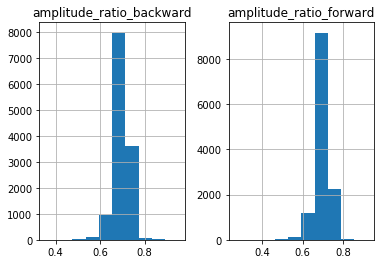

In [4]:
df.hist(['amplitude_ratio_forward','amplitude_ratio_backward']);

In [5]:
class MovementModel(sciunit.Model):
    def get_amplitude_ratio_forward(self):
        return 0.7
    def get_amplitude_ratio_backward(self):
        return 0.7
    
class AmplitudeRatioTest(sciunit.Test):
    
    score_type = sciunit.scores.ZScore
    
    attribute = 'amplitude_ratio'
    
    def validate_observation(self, observation):
        for col in ['mean','std']:
            f = getattr(observation['df'][self.attribute],col)
            observation[col] = f()
        return observation
        
    def generate_prediction(self, model):
        f = getattr(model,'get_%s' % self.attribute)
        return {'value': f()}
    
class AmplitudeRatioForwardTest(AmplitudeRatioTest):
    
    attribute = 'amplitude_ratio_forward'
    
class AmplitudeRatioBackwardTest(AmplitudeRatioTest):
    
    attribute = 'amplitude_ratio_backward'

In [6]:
model = MovementModel()
test_forward = AmplitudeRatioForwardTest(observation={'df':df})
test_backward = AmplitudeRatioBackwardTest(observation={'df':df})
suite = sciunit.TestSuite([test_forward,test_backward])

In [7]:
score_matrix = suite.judge(model)
score_matrix

,AmplitudeRatioForwardTest,AmplitudeRatioBackwardTest
MovementModel,Z = 0.05,Z = 0.09
